In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro, gen_trials_from_model_dir,find_opt_clust_num
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

In [35]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','fig5','lesion_dendro')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [36]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

In [37]:
rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

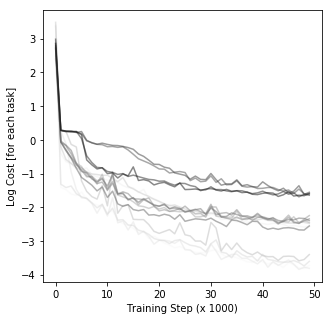

In [38]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

task_list = rule_trains

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
#     plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [39]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

Choosing 2 clusters
26
3 0.1398567224313016
4 0.14548031458826854
5 0.1503043682877406
6 0.15419951425295353
7 0.17362913492400073
8 0.18820141510601376
9 0.18436580313470546
10 0.19005026898876753
11 0.1930306562413518
12 0.2075187941617944
13 0.22057594854360052
14 0.22285262989796303
15 0.2223970481101501
16 0.2276954270848256
17 0.23166344221987473
18 0.22063172937363482
19 0.22145490363082843
20 0.22138395674102745
21 0.22550467456203022
22 0.23394483219317322
23 0.23636962248923496
24 0.23699906521514313
25 0.23772943030407087


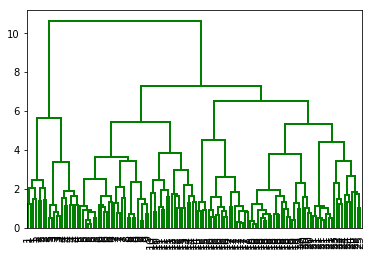

In [75]:
# def lesion_dendro_files(m, method = 'ward', criterion = 'distance', normalization_method='max'):
from sklearn import metrics
method = 'ward'
criterion = 'distance'
normalization_method='max'

CA = clustering.Analysis(m, data_type='epoch', normalization_method=normalization_method)
tick_names = [rule_name[key[0]]+' '+key[1] for key in CA.keys]

# Generate features and distance matrix.
D_og  = CA.h_normvar_all.T

Y = sch.linkage(D_og.T, method=method)

cel_max_d = find_opt_clust_num(D_og.T,Y)

print(cel_max_d)

for cel_max in range(3,cel_max_d):
    
    lesion_folder = 'lesion_dendro'
    clusters = fcluster(Y, cel_max, criterion='maxclust')
    score = metrics.silhouette_score(D_og.T, clusters)
    
    print(np.max(clusters),score)

    Z = sch.dendrogram(Y, orientation='top',labels = clusters,
                       leaf_font_size = 11,color_threshold=cel_max)

    index_top = Z['leaves']
    D = D_og[:,index_top]
    clusters_sorted = clusters[index_top]

    lesion_units_list = [None]
    for il, l in enumerate(np.unique(clusters)):
        ind_l = np.where(clusters == l)[0]
        # In original indices
        lesion_units_list += [CA.ind_active[ind_l]]

    # save cluster variables
    cluster_var = {'D':D,'Z':Z,
                'index_top':index_top,
                'clusters':clusters_sorted,
                'lesion_units_list':lesion_units_list,
                'max_d':cel_max_d,
                'criterion':'maxclust',
                'method':method}

    save_dir = os.path.join(m,lesion_folder)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    np.savez(os.path.join(save_dir,'cluster_dendro'+'_max_d'+str(np.max(clusters))+'.npz'),**cluster_var)

In [50]:
os.path.join(save_dir,'cluster_dendro.npz')

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/lesion_dendro_ward_distance_max_d25/cluster_dendro.npz'

In [159]:
# def lesions(m,rules=[],method = 'ward',max_d = 0,criterion = 'distance',other = False):

lesion_folder = 'lesion_dendro'
rules=[]

for cel_max in range(17,18):

    
    save_dir = os.path.join(m,lesion_folder,'cluster_dendro'+'_max_d'+str(cel_max)+'.npz')
    cluster_var = np.load(save_dir)
    lesion_units_list = cluster_var['lesion_units_list']

    perfs_store_list = list()
    perfs_changes = list()
    cost_store_list = list()
    cost_changes = list()

    for i, lesion_units in enumerate(lesion_units_list):
        print(lesion_units)
        model = Model(m)
        hp = model.hp
        if len(rules)==0:
            rules = hp['rule_trains']
        with tf.Session() as sess:
            model.restore()
            model.lesion_units(sess, lesion_units)

            perfs_store = list()
            cost_store = list()
            for rule in rules:
                n_rep = 16
                batch_size_test = 256
                batch_size_test_rep = int(batch_size_test / n_rep)
                clsq_tmp = list()
                perf_tmp = list()
                for i_rep in range(n_rep):
                    trial = generate_trials(rule, hp, 'random',
                                            batch_size=batch_size_test_rep)
                    feed_dict = tools.gen_feed_dict(model, trial, hp)
                    y_hat_test, c_lsq = sess.run(
                        [model.y_hat, model.cost_lsq], feed_dict=feed_dict)

                    # Cost is first summed over time, and averaged across batch and units
                    # We did the averaging over time through c_mask

                    # IMPORTANT CHANGES: take overall mean
                    perf_test = np.mean(get_perf(y_hat_test, trial.y_loc))
                    clsq_tmp.append(c_lsq)
                    perf_tmp.append(perf_test)

                perfs_store.append(np.mean(perf_tmp))
                cost_store.append(np.mean(clsq_tmp))

        perfs_store = np.array(perfs_store)
        cost_store = np.array(cost_store)

        perfs_store_list.append(perfs_store)
        cost_store_list.append(cost_store)

        if i > 0:
            perfs_changes.append(perfs_store - perfs_store_list[0])
            cost_changes.append(cost_store - cost_store_list[0])

    perfs_changes = np.array(perfs_changes)
    cost_changes = np.array(cost_changes)
    
    # save cluster variables
    lesion_var = {'perfs_changes':perfs_changes,
                'cost_changes':cost_changes}

    save_dir = os.path.join(m,lesion_folder,'perf','cluster_dendro'+'_max_d'+str(cel_max)+'.npz')

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    np.savez(os.path.join(save_dir,'cluster_dendro'+'_max_d'+str(cel_max)+'.npz'),**lesion_var)

None
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
[ 47  50  68  71  96  26 127   6]
Variables being optimized:


Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
[ 97 113  46  40  37  32]
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradr

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


In [160]:
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

Choosing 2 clusters


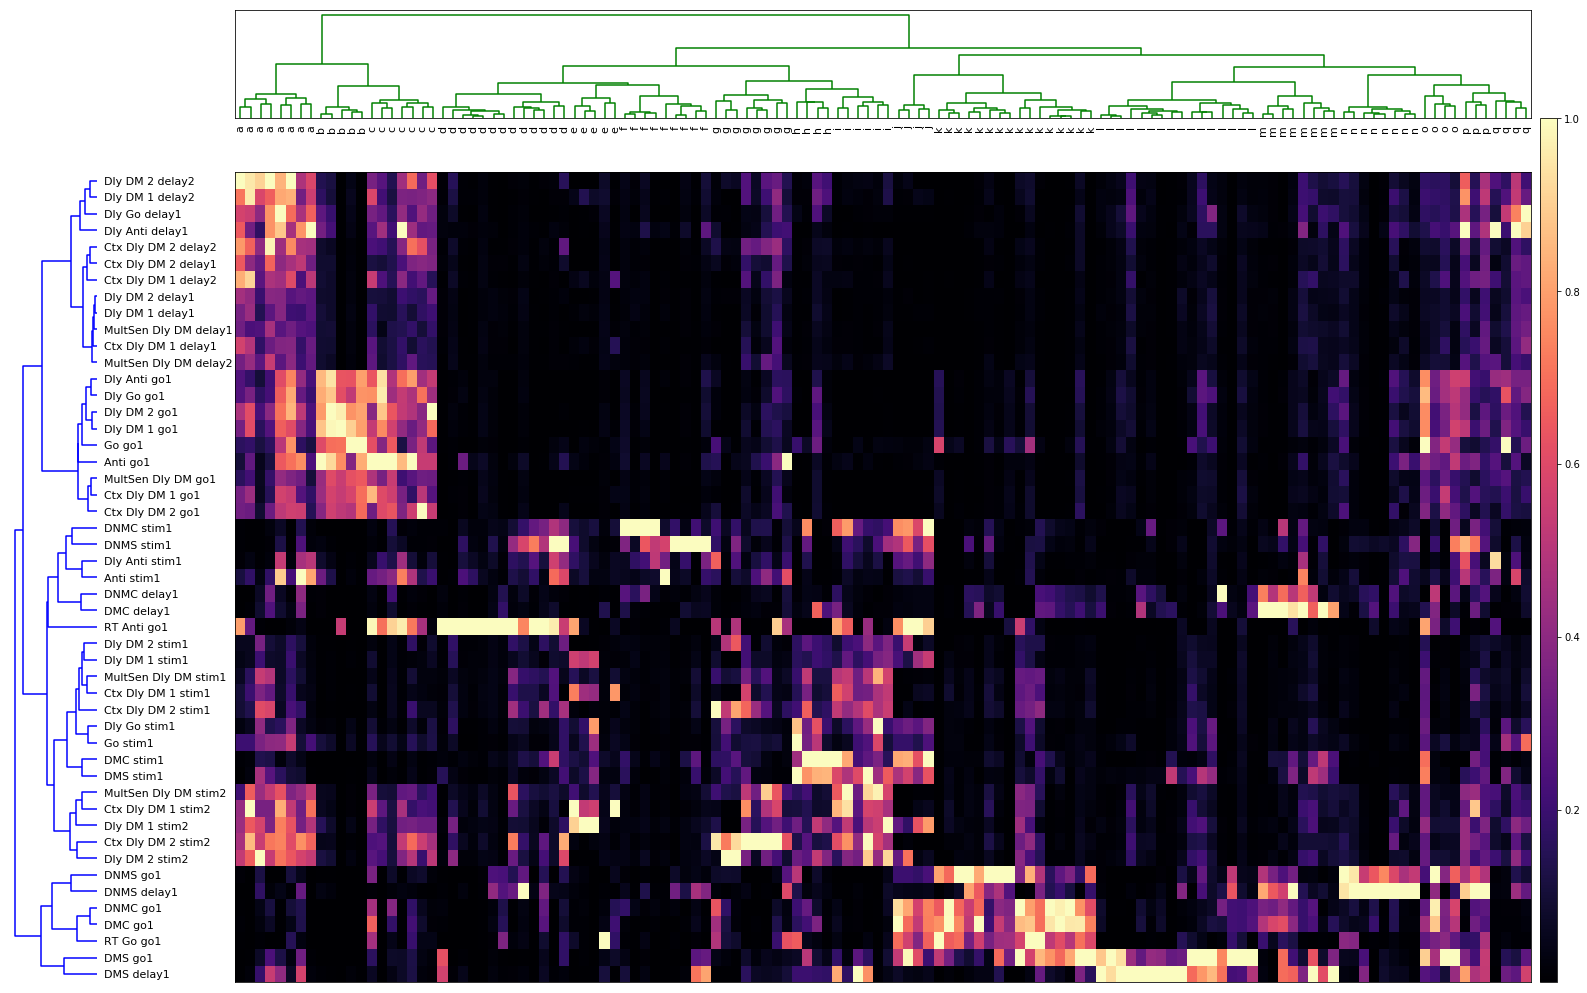

In [161]:
cel_max_d = 17
CA = clustering.Analysis(m, data_type='epoch', normalization_method=normalization_method)
tick_names = [rule_name[key[0]]+' '+key[1] for key in CA.keys]

# Generate features and distance matrix.
D  = CA.h_normvar_all.T

# Compute and plot dendrogram.
fig = plt.figure(figsize=(24, 15))
axdendro = fig.add_axes([0.09,0.1,0.05,0.75])

Y = sch.linkage(D, method=method)
max_d = find_opt_clust_num(D,Y)
clusters = fcluster(Y, max_d, criterion='maxclust')
Z = sch.dendrogram(Y, orientation='left',labels = tick_names,
                   leaf_font_size = 11,color_threshold=0)

axdendro.set_xticks([])
axdendro.spines['top'].set_visible(False)
axdendro.spines['right'].set_visible(False)
axdendro.spines['bottom'].set_visible(False)
axdendro.spines['left'].set_visible(False)

# Plot distance matrix.
axmatrix = fig.add_axes([0.22,0.1,0.75,0.75])
index_left = Z['leaves']
tick_names_sorted = [tick_names[i] for i in index_left]
D = D[index_left,:]

# cel_num = [CA.ind_active[x] for x in index_top]
axdendro_top = fig.add_axes([0.22,.9,0.75,0.1])
Y = sch.linkage(D.T, method=method)
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_opt_clust'

# cel_max_d = find_opt_clust_num(D.T,Y)
# cel_max_d = 17

clusters = fcluster(Y, cel_max_d, criterion='maxclust')


alphabet_labels = [alphabet[clusters[x]] for x in range(len(clusters))]
Z = sch.dendrogram(Y, orientation='top',labels = alphabet_labels, #CA.ind_active #clusters
               leaf_font_size = 11,color_threshold=cel_max_d)

# axdendro_top.set_xticks([])
axdendro_top.set_yticks([])

index_top = Z['leaves']
D = D[:,index_top]
clusters_sorted = clusters[index_top]
im = axmatrix.matshow(D, aspect='auto', origin='lower',cmap='magma')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.975,0.1,0.01,0.8])
plt.colorbar(im, cax=axcolor)

In [162]:
cel_max = cel_max_d #8 17
save_dir = os.path.join(m,'lesion_dendro')
cluster_var = np.load(os.path.join(save_dir,'cluster_dendro'+'_max_d'+str(cel_max)+'.npz'))

In [163]:
save_dir = os.path.join(m,'lesion_dendro','perf','cluster_dendro'+'_max_d'+str(cel_max)+'.npz')
lesion_var = np.load(os.path.join(save_dir,'cluster_dendro'+'_max_d'+str(cel_max)+'.npz'))

In [164]:
perfs_changes = lesion_var['perfs_changes']

rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

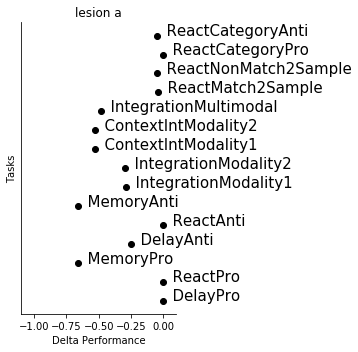

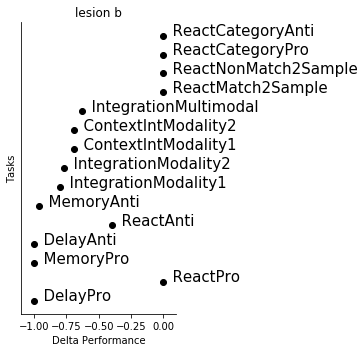

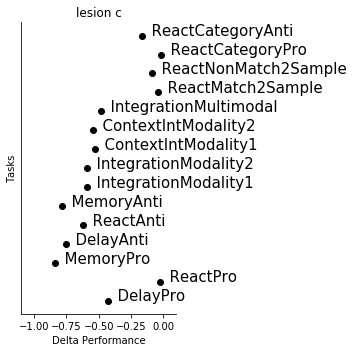

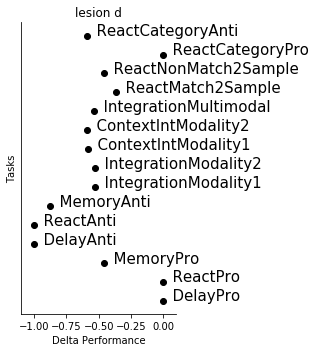

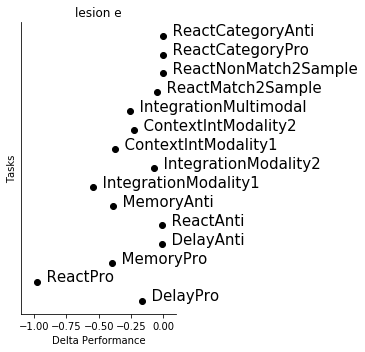

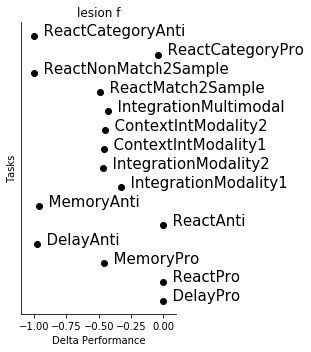

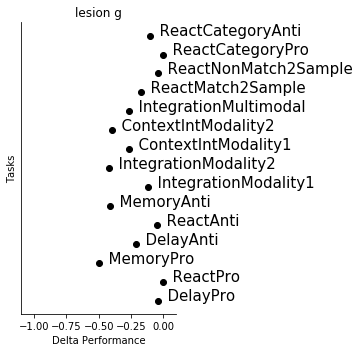

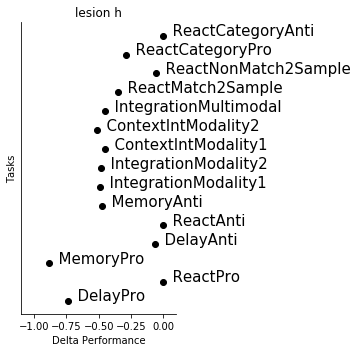

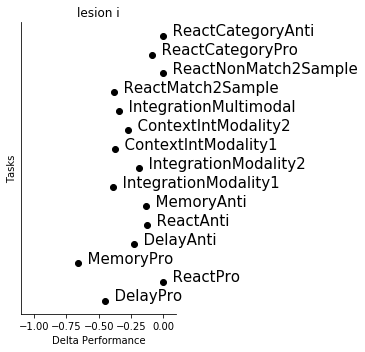

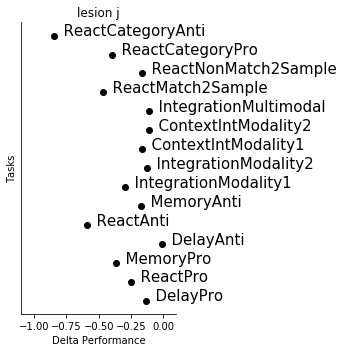

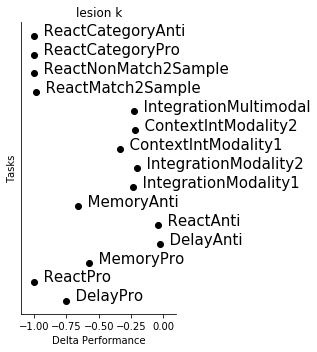

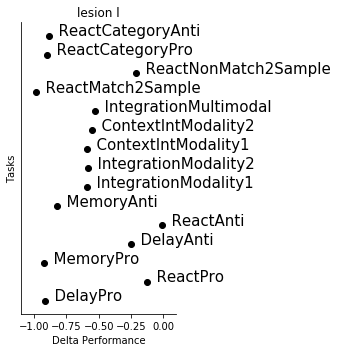

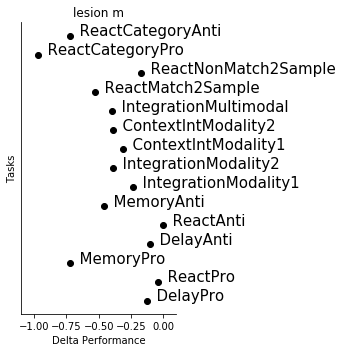

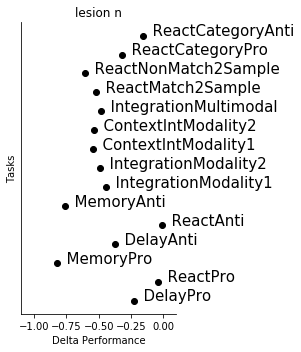

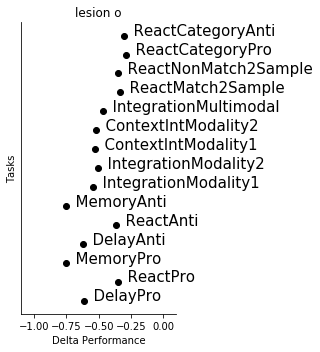

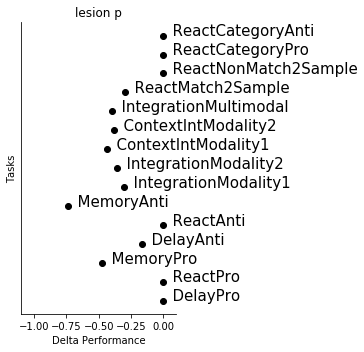

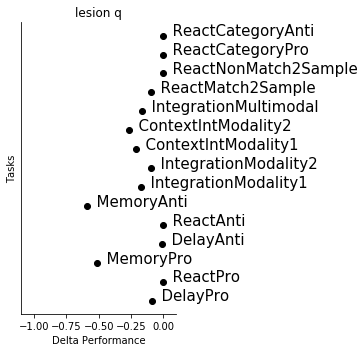

In [165]:
for l in range(len(perfs_changes)):
    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(121)
#     ax2 = plt.subplot(122)
    for y in range(15):
        plt.text(perfs_changes[l,y],y,'  '+rule_set_names[y],fontsize = 15)
        plt.plot(perfs_changes[l,y],y,'ok')
    plt.xlim((-1.1,.1))
    plt.title('lesion '+ alphabet[l+1])
    plt.xlabel('Delta Performance')
    plt.ylabel('Tasks')
    plt.yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    figname = 'perf_change'+'_lesion_'+ alphabet[l+1]
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')
    
    plt.show()

In [ ]:
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

In [83]:
rule = 'dmcgo'
lesion_units_list = []

def get_run_params(m,rule,lesion_units_list):

    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0

        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)

        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials(rule, hparams, 'test', noise_on = False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
    return params, hparams, trial, h_tf

In [94]:
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

In [544]:
alphabet

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [1093]:
# LESION GROUPS OF CLUSTERS

lesion_units_list = []
# [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][1]] # 
# [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][2]] # 
[lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][7]] # 
# [lesion_units_list.append(x) for x in cluster_var['lesion_units_list'][4]] # 

[None, None, None]

In [947]:
# # LESION ALL BUT

# lesion_units_list = range(128)
# # # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][20]] # t
# # # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][21]] # u

# # # m,n are inputs
# # # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][13]] # u
# # # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][14]] # u

# # # o,p are inhib?
# # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][15]] # u
# # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][16]] # u

# # #outputs? q,r,s,
# # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][17]] # u
# # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][18]] # u
# # [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][19]] # u

# #contin ring? a,b,c,d
# [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][1]] # u
# [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][2]] # u
# [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][3]] # u
# [lesion_units_list.remove(x) for x in cluster_var['lesion_units_list'][4]] # u

[None, None, None, None, None, None, None]

In [1110]:
rule = 'contextdelaydm1'

In [1111]:
# lesion_units_list = []

params, hparams, trial, h_tf = get_run_params(m,rule,[])
params_l, hparams_l, trial_l, h_tf_l = get_run_params(m,rule,lesion_units_list)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1

In [1112]:
# from tools_lnd import get_model_params
# w_in, b_in, w_out, b_out = get_model_params(m)

In [1113]:
# w_rec = w_in[20:]

In [1114]:
# for li in range(1,27):
#     delay_end = trial.epochs['delay1'][1]

#     for unit in cluster_var['lesion_units_list'][li]:

#         print( 'Cluster ' +  alphabet[li])
#         fig = plt.figure(figsize=(10,4),tight_layout=True,facecolor='white')

#         plt.subplot(121)
#         plt.plot(h_tf[:delay_end,:,unit])
#         plt.ylim([-0.1, 1.1])
#         plt.title('full : unit '+str(unit))

#         plt.subplot(122)
#         plt.plot(h_tf_l[:delay_end,:,unit])
#         plt.ylim([-0.1, 1.1])
#         plt.title('lesion : remove N units '+ str(len(lesion_units_list)))
#         plt.show()

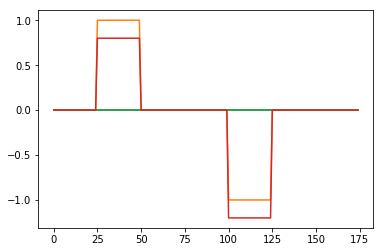

In [1115]:
plt.plot(trial.x[:,8,1:5])
plt.show()

In [1116]:
trial.stim_strength[:17,:]

array([[0.8, 1.2, 0.8, 1.2],
       [0.8, 1.2, 0.9, 1.1],
       [0.8, 1.2, 1. , 1. ],
       [0.8, 1.2, 1.1, 0.9],
       [0.9, 1.1, 0.8, 1.2],
       [0.9, 1.1, 0.9, 1.1],
       [0.9, 1.1, 1. , 1. ],
       [0.9, 1.1, 1.1, 0.9],
       [1. , 1. , 0.8, 1.2],
       [1. , 1. , 0.9, 1.1],
       [1. , 1. , 1. , 1. ],
       [1. , 1. , 1.1, 0.9],
       [1.1, 0.9, 0.8, 1.2],
       [1.1, 0.9, 0.9, 1.1],
       [1.1, 0.9, 1. , 1. ],
       [1.1, 0.9, 1.1, 0.9],
       [0.8, 1.2, 0.8, 1.2]])

In [1117]:
len(trial.stim_locs[8::16,:])

40

In [1118]:
range(8,len(h0),16)

[8, 24]

In [1119]:
lesion_epoch = 'stim1'

In [1120]:
np.shape(range(8,len(h0),16))

(2,)

In [1121]:
h0_ind = trial.epochs[lesion_epoch][0]+1
delay_end = trial.epochs[lesion_epoch][1] #trial.epochs['delay1'][1]

h0 = h_tf[h0_ind,:,:]
x_t = trial.x[h0_ind:delay_end,:,:]

ti_set = range(8,len(h0),16)

for ti in ti_set:
    h_t = vanilla_run_with_h0(params_l, x_t[:,ti,:], h0[ti,:], hparams_l)
    h_t1 = np.expand_dims(h_t[:-1,:], axis=1)
    
    if ti>ti_set[0]:
        h_all = np.append(h_all,h_t1,axis = 1)
    else:
        h_all = h_t1

In [1122]:
np.shape(h_all[-1,:,:])

(40, 128)

In [1123]:
h0 = h_all[-1,:,:]
x_t = trial.x[1+trial.epochs[lesion_epoch][1]:,ti_set,:]

for ti in range(len(h0)):
    h_t = vanilla_run_with_h0(params_l, x_t[:,ti,:], h0[ti,:], hparams_l)
    h_t1 = np.expand_dims(h_t[:-1,:], axis=1)
    
    if ti>0:
        h_all = np.append(h_all,h_t1,axis = 1)
    else:
        h_all = h_t1

In [1124]:
B = np.shape(trial.x)[1]
N = hparams['n_rnn']
T_inds = range(1+trial.epochs[lesion_epoch][1],len(trial.x))

b_rep = np.repeat(np.expand_dims(params[3],axis = 0),len(h_all),axis = 0)
y_hat = np.zeros((len(T_inds),len(ti_set),3))

for ti in range(len(ti_set)):
    h_t = h_all[:,ti,:]
    
    y_hat[:,ti,:] = np.dot(h_t,params[2])+b_rep

# y_loc = trial.y_loc[T_inds,ti_set]

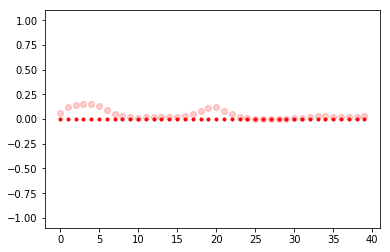

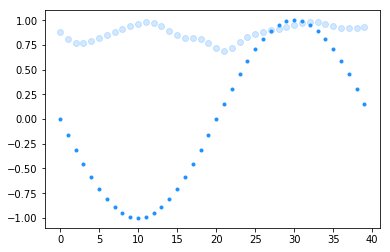

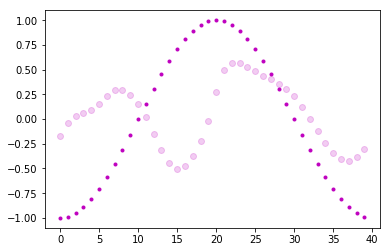

In [1125]:
color_set = ['r','dodgerblue','m']

for out_i in range(3):
    plt.plot(y_hat[-1,:,out_i], 'o', c = color_set[out_i],alpha = .2)
    plt.plot(trial.y[-1,ti_set,out_i],'.', c = color_set[out_i])
    
    plt.ylim([-1.1,1.1])

    plt.show()

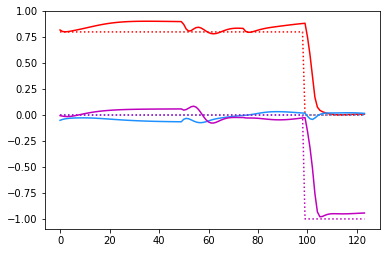

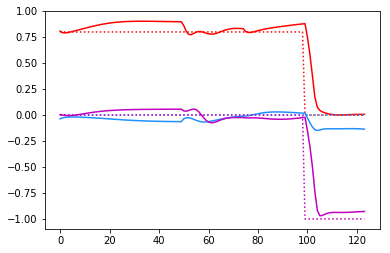

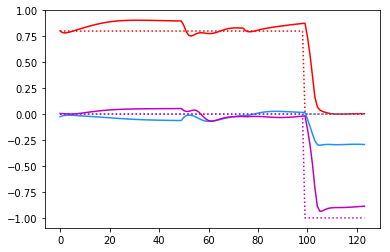

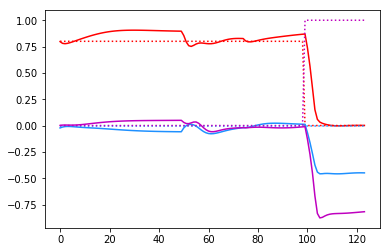

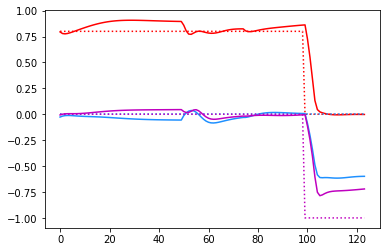

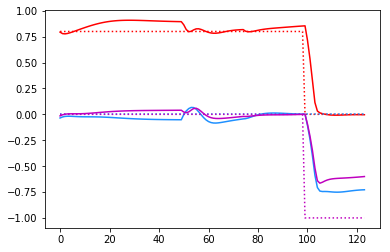

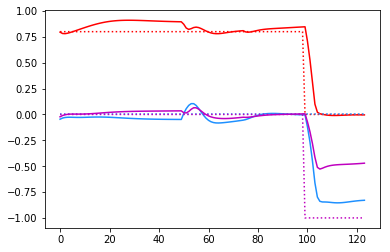

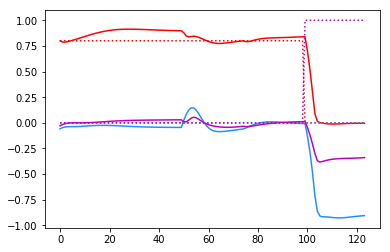

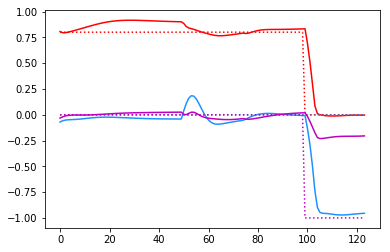

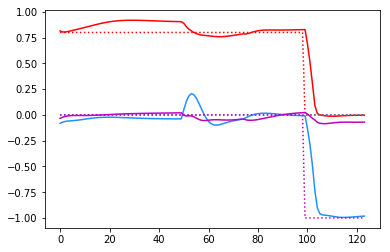

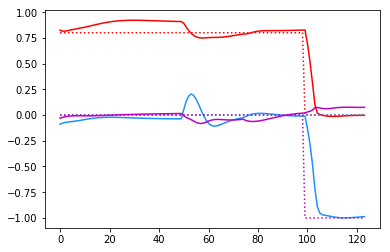

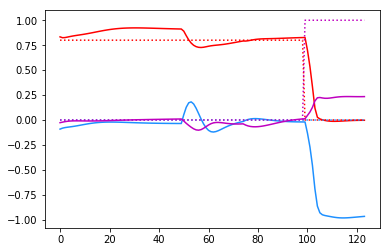

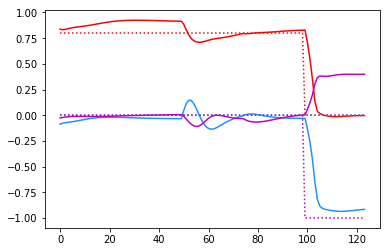

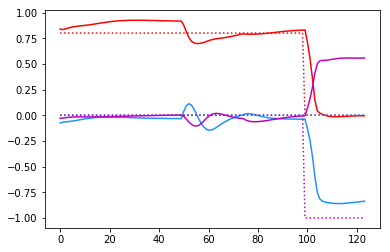

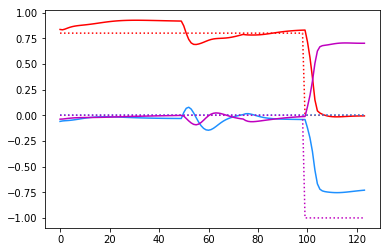

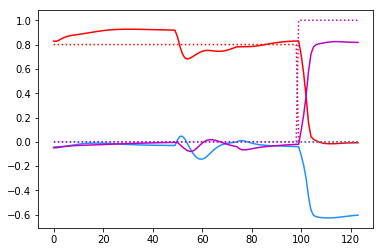

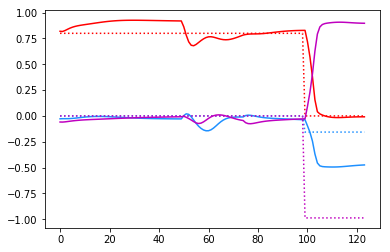

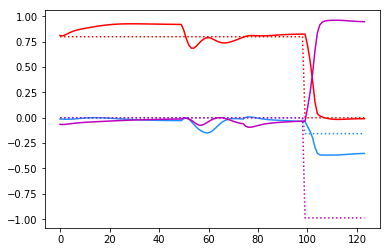

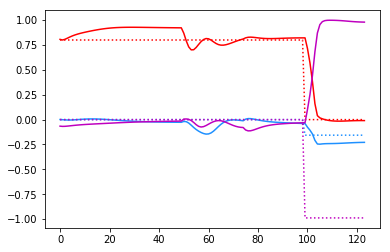

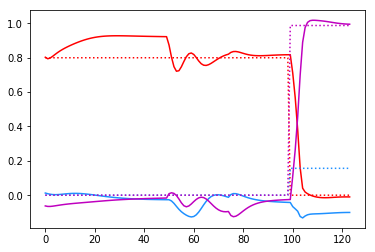

In [1109]:
color_set = ['r','dodgerblue','m']

for ti in range(20):
    for out_i in range(3):
        plt.plot(y_hat[:,ti,out_i], c = color_set[out_i])
        plt.plot(trial.y[T_inds,ti,out_i],':', c = color_set[out_i])

    plt.show()

In [6]:
def make_label_sets(rule_trains):
    label_set = {}
    label_set['anti'] = [('anti' in rule) or ('nogo' in rule) for rule in rule_trains]
    label_set['delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
    label_set['dm2'] = ['dm2' in rule for rule in rule_trains]
    label_set['dm1'] = ['dm1' in rule for rule in rule_trains]
    label_set['dmc'] = ['dmc' in rule for rule in rule_trains]
    label_set['react'] = ~np.array(label_set['delay'])

    label_reverse_set = {}
    label_reverse_set['anti'] = ~np.array(label_set['anti'])
    label_reverse_set['delay'] = ~np.array(label_set['delay'])
    label_reverse_set['dm2'] = ['dm1' in rule for rule in rule_trains]
    label_reverse_set['dm1'] = ['dm2' in rule for rule in rule_trains]
    label_reverse_set['dmc'] = ~np.array(label_set['dmc'])
    label_reverse_set['react'] = ~np.array(label_set['react'])
    return label_set, label_reverse_set

IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyGRU/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/lesion_fps_hierarchical_ward_distance_max_d3.5/lesion_var.npz'

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


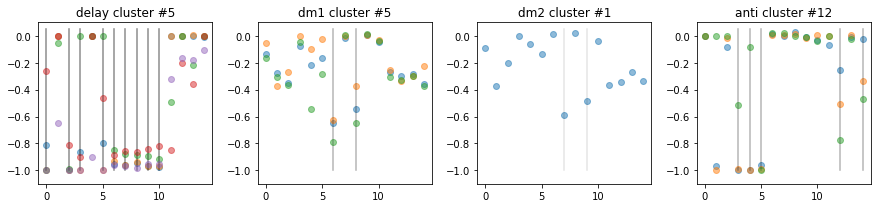

In [7]:
# m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'

method = 'ward'
# criterion = 'maxclust'
# max_d = 14
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
max_d = 3.5
lesion_folder = 'lesion_fps_hierarchical_ward_distance_max_d3.5'#'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
# lesion_folder = 'lesion_fps_hierarchical_ward_distance_max_d3.5'


# set of networks to compare
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['softplus','retanh']
w_init_set = ['randgauss','diag']
seed_set = ['0','1','2']
label_set, label_reverse_set = make_label_sets(rule_trains)

frac_true = {}
for motif in label_set.keys():
    frac_true[motif]=np.zeros(24)

fig = plt.figure(figsize=(len(label_set.keys())*3,3),tight_layout=True,facecolor='white')
net_ind = 0

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            
            rnn_type = rnn_type_set[rnn_type_i]
            activation = activation_set[activation_i]
            w_init = w_init_set[w_init_i]

            for seed in seed_set:
                
                net_ind+=1
            
                m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
                
                save_dir = os.path.join(m,lesion_folder)

                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

                perfs_changes = lesion_var['perfs_changes']
                
                for mi in range(len(label_set.keys())):
                    motif = label_set.keys()[mi]

                    in_group = [i for i, x in enumerate(label_set[motif]) if x]
                    out_group = [i for i, x in enumerate(label_reverse_set[motif]) if x]

                    metric = [np.mean(perfs_changes[ci,out_group]) - np.mean(perfs_changes[ci,in_group]) 
                                   for ci in range(len(perfs_changes))]

                    mlm = np.argmax(metric)

                    frac_true[motif][net_ind-1] = np.max(metric)
                    
                    if (metric[mlm]>.5):
                        
                        ax = plt.subplot(1,len(label_set.keys()),mi+1)
                        plt.plot(perfs_changes[mlm,:],'o',alpha = .5)
                        [plt.plot([x, x],[.05, -1],'-k',alpha = .1) for x in in_group]
                        plt.ylim((-1.1,.1))
                        plt.title(motif+' cluster #'+str(mlm+1))

In [ ]:
fig = plt.figure(figsize=(len(label_set.keys())*3,3),tight_layout=True,facecolor='white')
plt.subplot(len(label_set.keys()),1,mi+1)
shuff_lim = 950
for mi in range(len(label_set.keys())):
    plt.subplot(1,len(label_set.keys()),mi+1)
    motif = label_set.keys()[mi]
    plt.plot(np.sort(frac[motif],axis = 0)[shuff_lim,:],'k')
    plt.plot(frac_true[motif],'r')
    
    
    plt.title(motif)
    plt.xlabel('hyperparam network #')
    plt.ylabel('specificity metric')
    plt.ylim((0,1))
plt.show()

This figure shows that the delay motif is present in every network we looked at. Specificity index was greater than 95th percentile shuffles for every hyperparameter set. [excluding tanh, not aligned to cell axes]

In [ ]:
def make_label_sets(rule_trains):
    
    rule_trains_random = np.random.permutation(rule_trains)
    print(rule_trains_random)
    
    label_set = {}
    label_set['Anti'] = [('anti' in rule) for rule in rule_trains]
    label_set['Delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
#     label_set['Memory'] = [('delay' in rule) for rule in rule_trains]
    label_set['Modality2'] = ['dm2' in rule for rule in rule_trains]
    label_set['Modality1'] = ['dm1' in rule for rule in rule_trains]
    label_set['Random2'] = ['dm2' in rule for rule in rule_trains_random]
    label_set['Random3'] = ['anti' in rule for rule in rule_trains_random]
    label_set['Random9'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains_random]

    label_reverse_set = {}
    label_reverse_set['Anti'] = ~np.array(label_set['Anti'])
    label_reverse_set['Delay'] = ~np.array(label_set['Delay'])
#     label_reverse_set['Memory'] = ~np.array(label_set['Memory'])
    label_reverse_set['Modality2'] = ['dm1' in rule for rule in rule_trains]
    label_reverse_set['Modality1'] = ['dm2' in rule for rule in rule_trains]
    label_reverse_set['Random2'] = ['dm1' in rule for rule in rule_trains_random]
    label_reverse_set['Random3'] = ~np.array(label_set['Random3'])
    label_reverse_set['Random9'] = ~np.array(label_set['Random9'])
    return label_set, label_reverse_set

In [9]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains = ['fdgo', 'delaygo', 'fdanti']

rule_trains_str = '_'.join(rule_trains)

# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'lr'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-6)
seed = str(1)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/'

['dmsnogo' 'reactanti' 'contextdelaydm1' 'fdgo' 'dmsgo' 'dmcnogo' 'fdanti'
 'contextdelaydm2' 'reactgo' 'delaydm2' 'delayanti' 'delaydm1' 'dmcgo'
 'multidelaydm' 'delaygo']


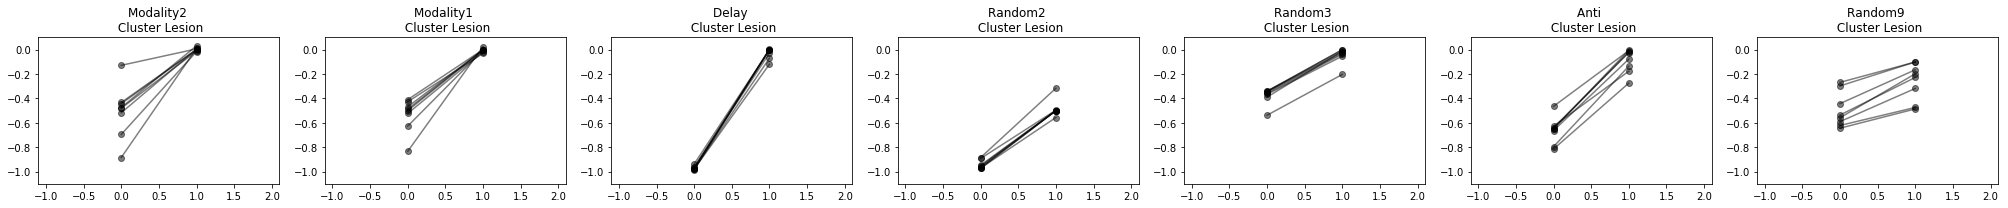

In [10]:
lesion_folder = 'lesion_fps_hierarchical_ward_maxclust_opt_clust'

# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU']
activation_set = ['softplus',]#,'retanh']
w_init_set = ['diag','randgauss']
seed_set = ['1','2']
label_set, label_reverse_set = make_label_sets(rule_trains)

frac_true = {}
for motif in label_set.keys():
    frac_true[motif]=np.zeros(24)

fig = plt.figure(figsize=(len(label_set.keys())*4,3),tight_layout=True,facecolor='white')
net_ind = 0

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            
            rnn_type = rnn_type_set[rnn_type_i]
            activation = activation_set[activation_i]
            w_init = w_init_set[w_init_i]

            for seed in seed_set:
                
                net_ind+=1
                m = os.path.join(p,'data','rnn','multitask',net,'final1','all',rnn_type,activation,
                                 w_init,str(len(rule_trains))+'_tasks',n_rnn+'_n_rnn',net_name+net_name2,
                                 seed)
                
                save_dir = os.path.join(m,lesion_folder)
                lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))
                perfs_changes = lesion_var['perfs_changes']
                
                for mi in range(len(label_set.keys())):
                    motif = label_set.keys()[mi]

                    in_group = [i for i, x in enumerate(label_set[motif]) if x]
                    out_group = [i for i, x in enumerate(label_reverse_set[motif]) if x]

                    metric = [np.mean(perfs_changes[ci,out_group]) - np.mean(perfs_changes[ci,in_group]) 
                                   for ci in range(len(perfs_changes))]

                    mlm = np.argmax(metric)

                    frac_true[motif][net_ind-1] = np.max(metric)
    
                    ax = plt.subplot(1,len(label_set.keys()),mi+1)
                    plt.plot(0,np.mean(perfs_changes[mlm,in_group]),'ok',alpha = .5)
                    plt.plot(1,np.mean(perfs_changes[mlm,out_group]),'ok',alpha = .5)
                    plt.plot([0,1],[np.mean(perfs_changes[mlm,in_group]),np.mean(perfs_changes[mlm,out_group])],
                             '-k',alpha = .5)
                    plt.ylim((-1.1,.1))
                    plt.xlim((-1.1,2.1))
                    
                    
                        
#                     if (metric[mlm]>.5):                        
#                         ax = plt.subplot(1,len(label_set.keys()),mi+1)
#                         plt.plot(perfs_changes[mlm,:],range(15),'o',alpha = .5)
#                         [plt.plot([.05, -1],[x, x],'-k',alpha = .1) for x in in_group]
#                         plt.xlim((-1.1,.1))
                    
                    plt.title(motif+' \n Cluster Lesion')
        
        

In [ ]:
motif = 'Delay'
[rule_trains[i] for i, x in enumerate(label_set[motif]) if x]

In [ ]:
motif = 'Random2'
[rule_trains[i] for i, x in enumerate(label_set[motif]) if x]

In [ ]:
motif = 'Random3'
[rule_trains[i] for i, x in enumerate(label_set[motif]) if x]

In [19]:
# set of networks to compare
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
data_folder ='final'
color_set = {}
color_set['lr'] = 'k'
color_set['untrained'] = 'dodgerblue'
color_set['no_noise'] = 'orangered'

seed_set = [str(1),]
max_d = 20
n_rnn = str(128)
x_ind_counter = 0
ax1_xticks = []
method = 'average'
criterion = 'maxclust'
all_epochs = ['stim1','stim2','delay1','delay2','go1']
n_tasks = str(len(rule_trains))
seed = 1
lr = -7
sigma_rec = 1/20
sigma_x = 2/20
ruleset = 'all'
w_rec_coeff  = 8/10
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder_all = 'data/rnn/multitask/stepnet/'

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))



net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
m = os.path.join(p,'data','rnn','multitask',net,'final','all',rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,str(seed))

In [20]:
# method = 'ward'
# max_d = 2.5
# criterion = 'distance'
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(max_d)
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

perfs_changes = lesion_var['perfs_changes']

In [21]:
rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

In [22]:
rule_names = {'fdgo':'DelayPro', 
              'reactgo':'ReactPro', 
              'delaygo':'MemoryPro', 
              'fdanti':'DelayAnti', 
              'reactanti':'ReactAnti',
              'delayanti':'MemoryAnti',
              'delaydm1':'DelayD1', 
              'delaydm2':'DelayD2', 
              'contextdelaydm1':'ContextDelayD1', 
              'contextdelaydm2':'ContextDelayD2', 
              'multidelaydm':'MultiDelayD',
              'dmsgo':'DM2SamplePro', 
              'dmsnogo':'DM2SampleAnti', 
              'dmcgo':'DM2CategoryPro', 
              'dmcnogo':'DM2CategoryAnti'}

In [23]:
label_set,label_reverse_set = make_label_sets(rule_trains)

In [24]:
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

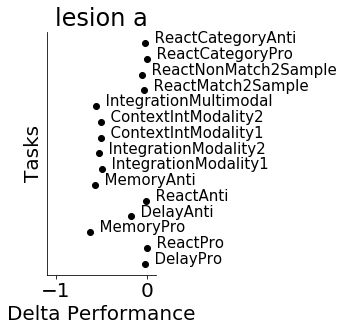

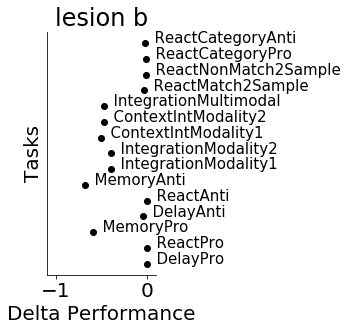

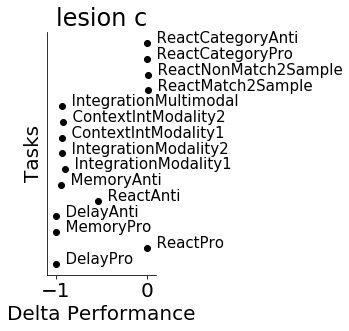

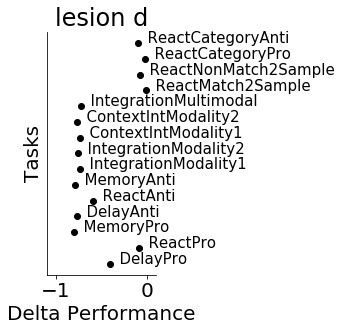

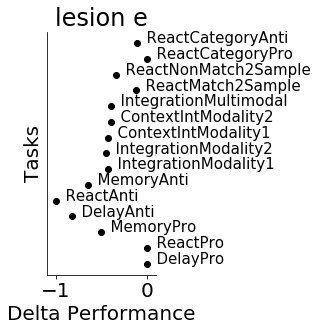

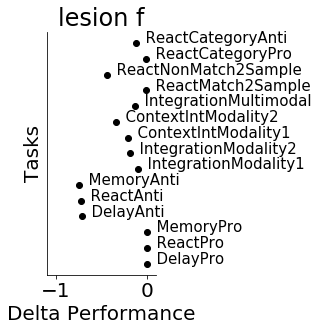

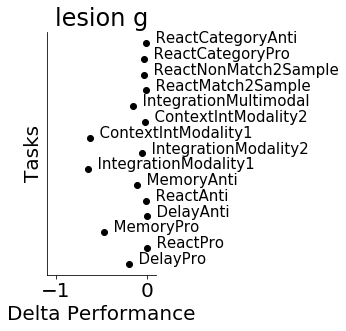

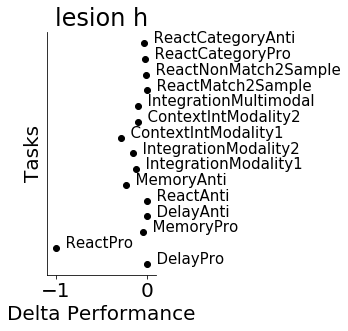

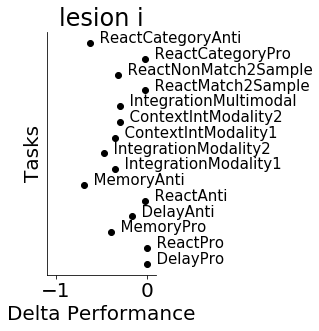

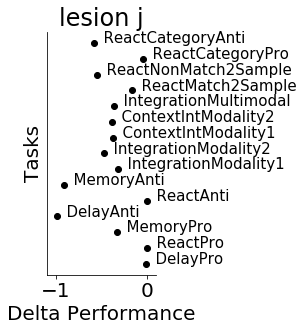

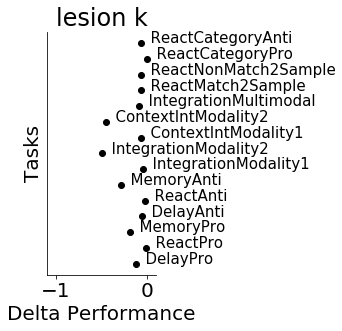

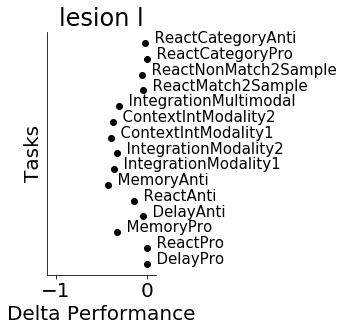

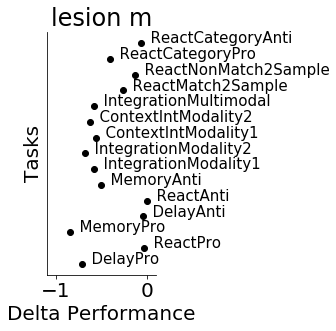

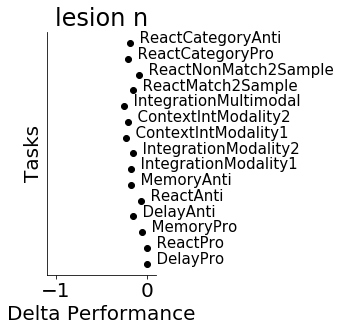

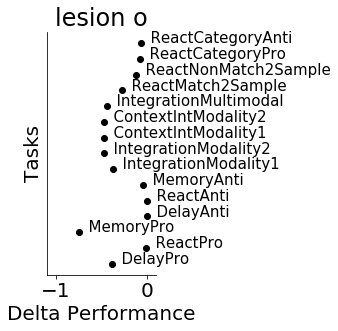

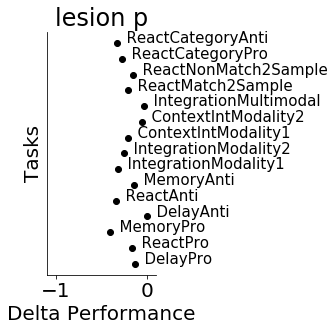

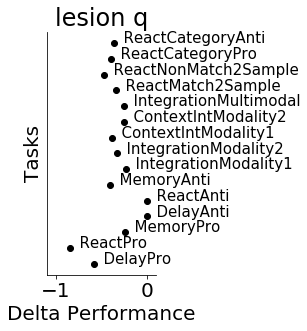

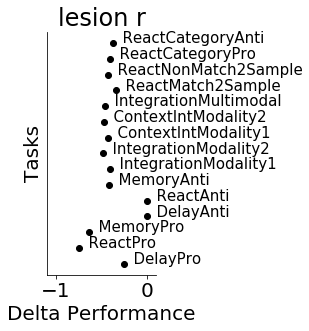

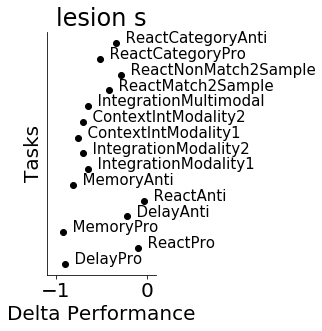

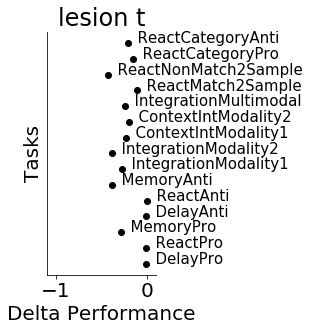

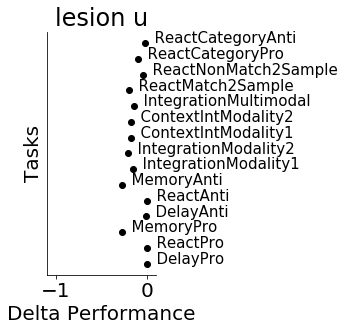

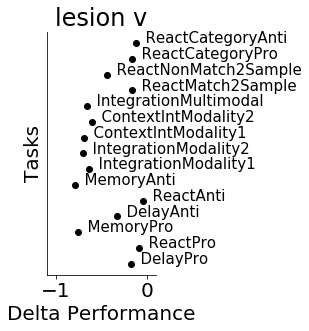

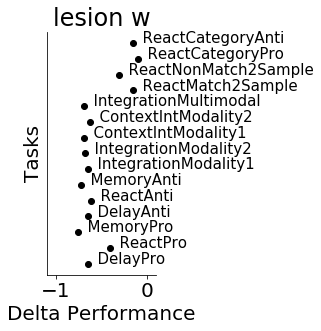

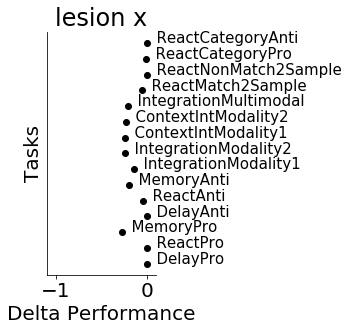

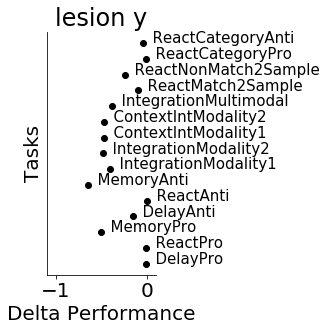

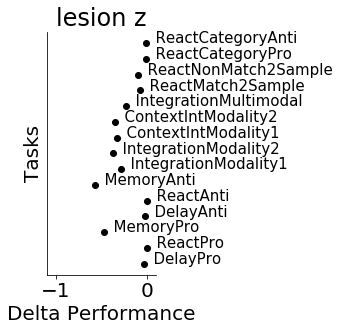

In [25]:
for l in range(len(perfs_changes)):
    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(121)
#     ax2 = plt.subplot(122)
    for y in range(15):
        plt.text(perfs_changes[l,y],y,'  '+rule_set_names[y],fontsize = 15)
        plt.plot(perfs_changes[l,y],y,'ok')
    plt.xlim((-1.1,.1))
    plt.title('lesion '+ alphabet[l+1])
    plt.xlabel('Delta Performance')
    plt.ylabel('Tasks')
    plt.yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    figname = 'perf_change'+'_lesion_'+ alphabet[l+1]
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')
    
    plt.show()

KeyError: 'Anti'

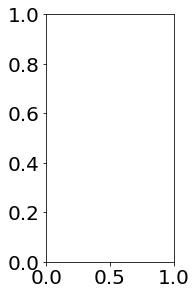

In [26]:
cluster_number = {}
cluster_number['Anti'] = 5
cluster_number['Delay'] = 2
cluster_number['Modality2'] = 10
cluster_number['Modality1'] = 6
cluster_names = ['Anti','Delay','Modality2','Modality1']
save_dir = os.path.join(figpath,'lesion_clusters_combined')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fontsize = 20
tick_fontsize = fontsize*.75
label_fontsize = fontsize*1
plt.rcParams.update({'font.size': fontsize})

for key_i in range(len(cluster_number.keys())):
    
    fig = plt.figure(figsize=(3,4.5),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)
    
    key = cluster_names[key_i]

    perfs_change_cluster = perfs_changes[cluster_number[key],:]

    len_key = np.sum(label_set[key])
    plt.plot(np.ones(len_key),perfs_change_cluster[label_set[key]],
             '.k',markersize = 15,alpha = .3)

    len_key = np.sum(label_reverse_set[key])
    plt.plot(np.zeros(len_key),perfs_change_cluster[label_reverse_set[key]],
             '.k',markersize = 15,alpha = .3)
    
    plt.plot([1,0],[np.mean(perfs_change_cluster[label_set[key]]),
                                                 np.mean(perfs_change_cluster[label_reverse_set[key]])],'-k')

    plt.ylabel('Perf. Change',fontsize = fontsize)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Not '+key,key],rotation = 45,ha = 'right',fontsize = tick_fontsize)
    ax.set_yticks([0,-.5,-1])
    ax.set_yticklabels([0,-.5,-1],fontsize = tick_fontsize)
    plt.xlabel('Tasks',fontsize = fontsize)
    ax.xaxis.set_label_coords(.5, -.45)
    plt.title('Lesion Cluster :',fontsize = fontsize, color = 'k',x=0)
    
    #color lesion letter
    text_xloc = 1.5
    text_yloc = .15
    xi = cluster_number[key]+1
    c = color_palette[(xi-1)%len(color_palette)]
    rect=mpatches.Rectangle((text_xloc,text_yloc),.7,.3, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(text_xloc*1.1,text_yloc+.08,alphabet[xi],color =c,fontweight='bold',rotation = 0,fontsize = 24)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#         ax.set_xticks([])
    plt.ylim([-1.2,.2])
    plt.xlim([-1,2])

    figname = 'perf_change_'+key
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')

In [ ]:
# h_all_byepoch, h_all_byrule, _, _ = make_h_all(m,mode = 'test')

In [28]:
from network import get_perf
from task import generate_trials
from tools_lnd import take_names

fontsize = 20
tick_fontsize = fontsize*.75
label_fontsize = fontsize*1
plt.rcParams.update({'font.size': fontsize})

def plot_lesion(m,task_list,epoch,lesion_units_list,cluster_label = [],lesion_num = []):

    fig = plt.figure(figsize=(4, 4))
    cmap = plt.get_cmap('hsv')
#     c_full = cmap(0.1)
#     c_lesion = cmap(.6)
    c_full = 'dodgerblue'
    c_lesion = 'r'#'brown'
    al = .5
    lw = 6
    
    from tools_lnd import get_model_params
    w_in, b_in, w_out, b_out = get_model_params(m)

    D_out = {}
    D_out['axes'] = w_out[:,1:]
    D_out['labels'] = ['W_{out} cos(theta)','W_{out} sin(theta)']

    model = FixedPoint_Model(m)
    hp = model.hp
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)

        for ri in range(len(task_list)):
            rule = task_list[ri]
            trial = generate_trials(rule, hp, 'test', noise_on = False)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
            _components = 3
            pca = PCA(n_components = n_components)
            D_pca = {}
            
            if epoch in trial.epochs.keys():
                T_inds = get_T_inds(trial,epoch) # grab epoch time indexing
            else:
                T_inds = get_T_inds(trial,'go1')
                
            h =  np.transpose(h_all_byrule[rule][T_inds,:,:],(2,1,0))# h_tf[:,range(1,n_trials),:],(2,1,0))
            Xh = np.reshape(h,(h.shape[0],-1))
            fp_pca = pca.fit_transform(Xh.T)
            D_pca['axes'] = pca.components_.T
            D_pca['labels'] = ['PCA '+str(x+1) for x in range(n_components)]

            for trial_i in range(3,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/20)): #includes mod2 trials
                c = cmap(trial.y_loc[-1,trial_i]/(2*np.pi))

#                 ax = plt.subplot(len(task_list),2,1+(2*ri))
                ax = fig.add_axes([0,ri*.6,.3,.3]);
                X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_pca['axes'])
                plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
                plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                X_dot = np.dot(h_tf[:,trial_i,:],D_pca['axes'])
                plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
                plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_lesion,alpha = al,linewidth = lw)
                
                _, rule_name, _, _ = take_names(epoch,rule)
                plt.title(cluster_label[ri]+r"$\bf{" + rule_name + "}$", y=.98, x = 1)

                plt.xlabel(D_pca['labels'][0])
                plt.ylabel(D_pca['labels'][1])
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False) 
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)  
                ax.set_xticks([]) 
                ax.set_yticks([])

#                 ax = plt.subplot(len(task_list),2,2+(2*ri))
                ax = fig.add_axes([.5,ri*.6,.3,.3]);
                X_rule = np.dot(h_all_byrule[rule][:,trial_i,:],D_out['axes'])
                plt.plot(X_rule[:,0],X_rule[:,1],c = c_full,alpha = al,linewidth = lw)
                plt.plot(X_rule[-1,0],X_rule[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                X_dot = np.dot(h_tf[:,trial_i,:],D_out['axes'])
                plt.plot(X_dot[:,0],X_dot[:,1],c = c_lesion,alpha = al,linewidth = lw)
                plt.plot(X_dot[-1,0],X_dot[-1,1],'^',c = c_full,alpha = al,linewidth = lw)

                plt.xlabel('OUT 1')
                plt.ylabel('OUT 2')
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False) 
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)  
                ax.set_xticks([]) 
                ax.set_yticks([])
                

    figname = 'viz_traj_'+'_'.join(task_list)+str(lesion_num)
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')

In [29]:
# lesion cluster
n_components = 2
task_list = ['reactgo', 'delaygo']
cluster = cluster_number['Delay']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'go1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Delayed Response \n motif : ','Task w Delayed Response \n motif : '],
            lesion_num = cluster)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameter

NameError: global name 'h_all_byrule' is not defined

<Figure size 288x288 with 0 Axes>

In [ ]:
# lesion cluster
task_list = ['delaygo', 'delayanti']
cluster = cluster_number['Anti']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'stim1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Anti Stimulus \n motif : ','Task w Anti Stimulus \n motif : '],lesion_num = cluster)

In [ ]:
# lesion cluster
task_list = ['contextdelaydm1','contextdelaydm2']
cluster = cluster_number['Modality2']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'go1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Modality 2 \n motif : ','Task w Modality 2 \n motif : '],lesion_num = cluster)

In [ ]:
# lesion cluster
task_list = ['contextdelaydm2','contextdelaydm1']
cluster = cluster_number['Modality1']+1
lesion_units_list = cluster_var['lesion_units_list'][cluster]
epoch = 'go1'
plot_lesion(m,task_list,epoch,lesion_units_list,
            cluster_label = ['Task w/o Modality 1 \n motif : ','Task w Modality 1 \n motif : '],lesion_num = cluster)

In [ ]:
for rule in ['contextdelaydm1','contextdelaydm2']:#
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0

#         model.lesion_units(sess, lesion_units)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict

In [ ]:
def plot_N3D(ax, X, D, clist, linewidth = 6, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
#         ax.scatter3D(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],'^',c = c, linewidth = linewidth, alpha = alpha)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
#         ax.scatter3D(X_trial[0,0],X_trial[0,1],X_trial[0,2],'.',c = c, linewidth = linewidth, alpha = alpha)

In [ ]:
def make_ax_nice(ax, ax_labels, plot_zero_plane = True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_zticks([])
    epoch_name_ax, rule_name_ax, _, _ = take_names(ax_labels[0],ax_labels[1])
    ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1', labelpad=0)
    ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2', labelpad=0)
    ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3', labelpad=0)
    
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1+.1*x1,x2+.1*x2])
    ax.set_ylim([y1+.1*y1,y2+.1*y2])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    
    if plot_zero_plane:
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
        ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10)
#         ax.text(x1, y1, 0, 'Output Null', (1,0,0))
    elif len(zlabel)>0:
        ax.set_zlabel(zlabel,labelpad=-10)
    ax.set_zlim([-1.1,1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([-1,1])

In [ ]:
def plot_N3D(ax, X, D, clist, linewidth = 6, alpha = .5, linestyle = '-'):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        elif len(clist)==1:
            c = clist[0]
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)

In [101]:
trial.epoch.keys()

NameError: name 'trial' is not defined

In [161]:
from tools_lnd import make_FP_axs, get_model_params #get_filename, 
def compare_fp_lesions(m,cluster_var,lesion_cluster,rule_set,color_by = 'stim',n_components = 3,fontsize=20,
                       review = False, epoch_set = [], q_thresh = 1e-3,t = 0, ri_axs = 0, view_init = [-51,30], 
                       epoch_ri=[]):
    
    if review:
        lf = 'lesion_fps_review'
    else:
        lf = 'lesion_fps'
        
    lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
    cmap = plt.get_cmap('hsv')
    c_full = 'dodgerblue'#cmap(0.1)
    c_lesion = 'r'#'brown'#cmap(.6)
    h_all_byepoch, h_all_byrule, _, _ = make_h_all(m)
    
    plt.rcParams.update({'font.size': fontsize})
    tick_fontsize = fontsize*.75
    label_fontsize = fontsize*1

    for ri in range(len(task_list)):
        rule = task_list[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        B = np.shape(trial.y_loc)[1]
        N = np.shape(trial.y_loc)[1]
        trial_set = range(0,B,int(B/10))
        
        if len(epoch_ri)==0:
            epoch = epoch_set[ri_axs]
        else:
            epoch =  epoch_ri  
            
        rule = rule_set[ri_axs]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        filename,_ = get_filename(trial,epoch,t)
        f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')    
        D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
        w_in, b_in, w_out, b_out = get_model_params(m)

#         D_use = -D_use
        if rule == 'delaygo':
            D_use = -D_use
        else:
            D_use[:,1] = -D_use[:,1]
            
        D_use[:,2] = w_out[:,2]
        axes_labels = [epoch, rule]

        epoch_list = sorted(trial.epochs.items(), key=lambda x: x[1])
        
        if len(epoch_set)==0:
            epoch_set = [epoch_list[x][0] for x in range(len(epoch_list))]

        for trial_num in [t,]:##range(0,B,int(B/5))
            out_theta = int(180*trial.y_loc[-1,trial_num]/np.pi)

            for plot_num in range(0,len(epoch_set)):
                
                fig = plt.figure(figsize=(7,7),tight_layout=True,facecolor='white')

                epoch = epoch_set[plot_num]
                epoch_name, task_name, _, _ = take_names(epoch,rule)

                ax = plt.subplot(1,1,1, projection='3d')
                w_color = .005
                ax.w_xaxis.set_pane_color((w_color, w_color, w_color, w_color))
                ax.w_yaxis.set_pane_color((w_color, w_color, w_color, w_color))
                ax.w_zaxis.set_pane_color((w_color, w_color, w_color, w_color))

                lesion_units_list = cluster_var['lesion_units_list'][lesion_cluster]
                
                if epoch[0]=='s':
                    filename,_ = get_filename_fp(trial,epoch,trial_num)
                elif rule[0]=='d':
                    filename,_ = get_filename_fp(trial,epoch,0)
                else:
                    filename,_ = get_filename_fp(trial,epoch,trial_num)
                    
                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(lesion_cluster),rule,filename)
                c = c_lesion
                
                plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
                                         rand_step_coef = 0,
                                         al = .2, 
                                         linestyle = '-', 
                                         n_steps = 60,
                                         n_jit = 0
                                         ,c = c, 
                                         q_thresh = q_thresh)

                lesion_units_list = []
                
                if epoch[0]=='s':
                    filename,_ = get_filename_fp(trial,epoch,trial_num)
                elif rule[0]=='d':
                    filename,_ = get_filename_fp(trial,epoch,0)
                else:
                    filename,_ = get_filename_fp(trial,epoch,trial_num)
                    
                f = os.path.join(m,lesion_folder,lf,'tf_fixed_pts_lesion'+str(0),rule,filename)
                c = c_full

                plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,trial_num,epoch,f,
                                         rand_step_coef = 0,
                                         al = .2, 
                                         linestyle = '-', 
                                         n_steps = 60,
                                         n_jit = 0,
                                         c = c, 
                                         q_thresh = q_thresh)

                tit = 'Task : '+ r"$\bf{" + task_name + "}$" +'\n Period : '+ r"$\bf{" + epoch_name.capitalize() + "}$"
                plt.title(tit,fontsize = fontsize,y = .9)

                ax.set_xlim([-1.2,1.2])
                ax.set_ylim([-1.2,1.2]) 
                make_ax_nice(ax,axes_labels)
                
                ax.set_yticks([])
                ax.set_xticks([])
                ax.set_zticks([])
                
                ax.view_init(azim=view_init[0], elev=view_init[1]) #(azim=-51, elev=30)
                ax.dist = 12
            

                figname = 'lesion'+str(lesion_cluster)+'_'+rule+'_'+epoch+'_'+str(out_theta)
                if not os.path.exists(os.path.join(figpath,'vis_fp_lesion')):
                    os.makedirs(os.path.join(figpath,'vis_fp_lesion'))
                plt.savefig(os.path.join(figpath,'vis_fp_lesion',figname+'.pdf'))
                plt.show()

In [162]:
def plot_FP_jitter_3D_lesion(lesion_units_list,ax,m,D_use,rule,t_num,fp_epoch,f,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k', q_thresh = 1e-3):#, q_thresh = 1e-8

    ms = 20
    lw = 6
    
    fp_struct = np.load(f)
    step_fps = fp_struct['xstar']
    
#     if fp_epoch=='stim1':
#         fp_use = np.where(fp_struct['qstar']<q_thresh/100)[0] 
#     else:
#         fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
        
    fp_use = np.where(fp_struct['qstar']<q_thresh)[0]
    
    
    sorted_fps = fp_struct['xstar'][fp_use,:]
  
    fp_project = np.dot(sorted_fps,D_use)

    # runs jitters around fps
    stable = np.empty(len(sorted_fps))
    for fp_ind in range(len(sorted_fps)):

        dst_scale = 300

        facecolors_3d = c
        facecolors_2d = c
        edgecolors = 'w'

        for jit in range(n_jit):
            h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
            h_t = vanilla_run_with_h0(params, x_t, h0, hp)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = 3)


        if fp_epoch=='stim1':
            ax.scatter(fp_project[fp_ind,0],fp_project[fp_ind,1],fp_project[fp_ind,2],'o',
                      s = dst_scale, edgecolors = edgecolors, facecolors = facecolors_3d, alpha = al)
        else:
            ax.scatter(fp_project[fp_ind,0],fp_project[fp_ind,1],fp_project[fp_ind,2],'o',
                      s = dst_scale, edgecolors = edgecolors, facecolors = facecolors_3d, alpha = al)
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)
        hp = model.hp
        alpha = hp['dt']/hp['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hp, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing
        x_t = np.matlib.repmat(trial.x[T_inds[1],t_num,:],n_steps,1)
            
            
        #runs one state for n_steps starting from initial conditions
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hp)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,alpha = .5, linewidth = lw)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-k',linewidth = lw/2)
            ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'x',c = c,markersize = ms,markeredgewidth = 3)
            ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^',c = c,markersize = ms,markeredgewidth = 3)
            ax.plot3D(jitter[:1,0],jitter[:1,1],jitter[:1,2],'xk',markersize = ms/2,markeredgewidth = 1)
            ax.plot3D(jitter[-2:-1,0],jitter[-2:-1,1],jitter[-2:-1,2],'^k',markersize = ms/2,markeredgewidth = 1)
         
    ax.dist = 12

In [163]:
def lesion_endpt_diff(lesion_units_list,m,rule,n_steps = 100):#, q_thresh = 1e-8
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)
        hp = model.hp
        alpha = hp['dt']/hp['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        trial = generate_trials(rule, hp, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h_lesion, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

#     model = Model(m)
#     with tf.Session() as sess:
#         model.restore()
#         model._sigma=0
#         hp = model.hp
#         alpha = hp['dt']/hp['tau']
#         var_list = model.var_list
#         params = [sess.run(var) for var in var_list]

#         trial = generate_trials(rule, hp, mode='test',noise_on=False)
#         feed_dict = tools.gen_feed_dict(model, trial, hp)
#         h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
    return h_lesion #, h_tf 

In [164]:
# def get_filename_fp(trial, epoch,t):
#     ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
#     nonzero_stim = trial.stim_locs[0,:]<100
#     stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
#     filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc+'.npz'

#     return filename, ind_stim_loc

def get_filename_fp(trial, epoch,t):
    ind_stim_loc  = 180*trial.y_loc[-1,t]/np.pi
    filename = epoch+'_'+str(round(ind_stim_loc,2))+'.npz'

    return filename, ind_stim_loc

def get_filename(trial, epoch,t):
    ind_stim_loc  = 180*trial.y_loc[-1,t]/np.pi
    filename = epoch+'_'+str(round(ind_stim_loc,2))+'.npz'

    return filename, ind_stim_loc

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

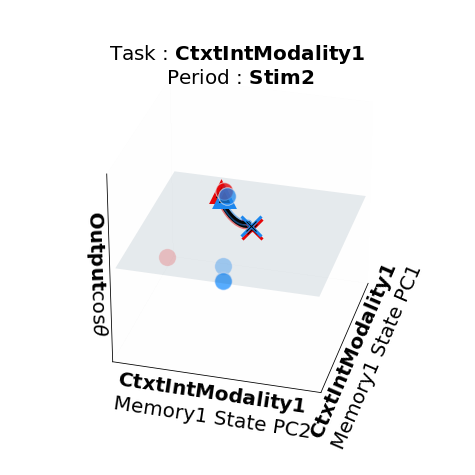

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

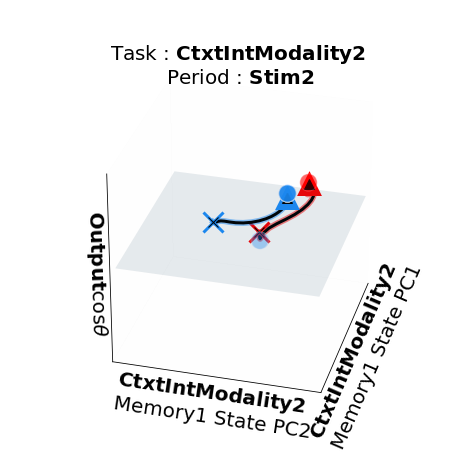

In [168]:
t=0
lesion_cluster = 11 #MOD2
color_by = 'stim'

task_list = ['contextdelaydm1',]
compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                   epoch_set = ['stim2',], q_thresh = 1e-9, t=t, view_init = [195,30], epoch_ri = 'delay1') #-5
# compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                    epoch_set = ['go1',], q_thresh = 1e-6, t=t) #-5

task_list = ['contextdelaydm2',]
compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                   epoch_set = ['stim2',], q_thresh = 1e-9, t=t, view_init = [195,30], epoch_ri = 'delay1')
# compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                    epoch_set = ['go1',], q_thresh = 1e-6, t=t)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

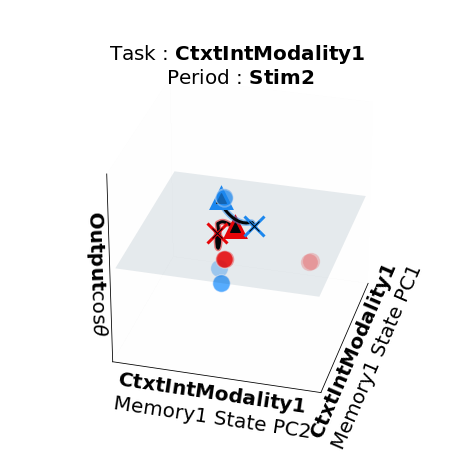

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

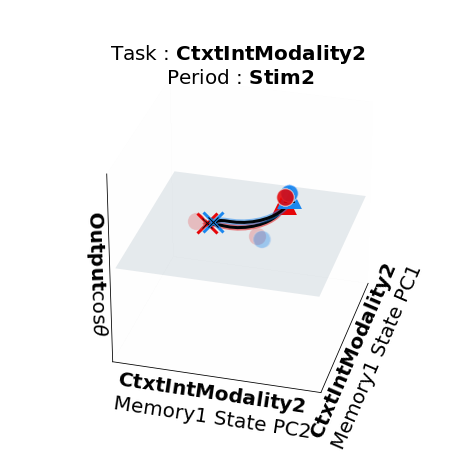

In [169]:
lesion_cluster = 7 #MOD1
color_by = 'stim'

for t in [0,]:
    task_list = ['contextdelaydm1',]
    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['stim2',], q_thresh = 1e-9, t=t, view_init = [195,30], epoch_ri = 'delay1') #-5
#     compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                        epoch_set = ['go1',], q_thresh = 1e-5, t=t) #-5

    task_list = ['contextdelaydm2',]
    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['stim2',], q_thresh = 1e-9, t=t, view_init = [195,30], epoch_ri = 'delay1')
#     compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                        epoch_set = ['go1',], q_thresh = 1e-5, t=t)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

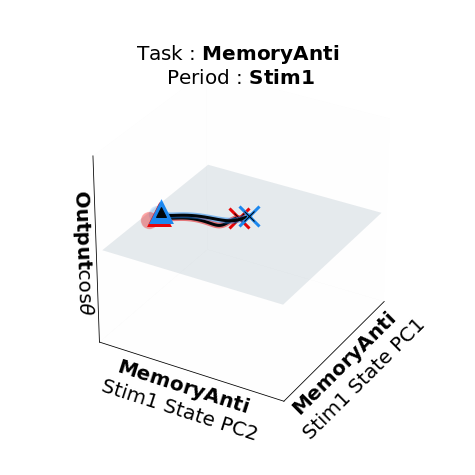

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

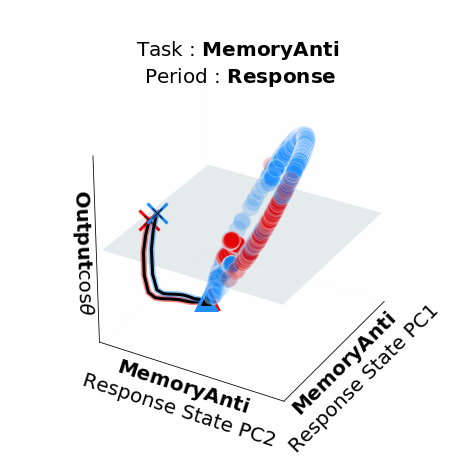

In [154]:
for t in [2,]:
    lesion_cluster = 6
    task_list = ['delayanti',]
    color_by = 'stim'

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['stim1',], q_thresh = 1e-9, t=t, view_init = [210,30])

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['go1',], q_thresh = 1e-3, t=t, view_init = [210,30])
    
    
#     lesion_cluster = 3

#     compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                        epoch_set = ['stim1',], q_thresh = 1e-9, t=t, view_init = [210,30])

#     compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
#                        epoch_set = ['go1',], q_thresh = 1e-5, t=t, view_init = [210,30])

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

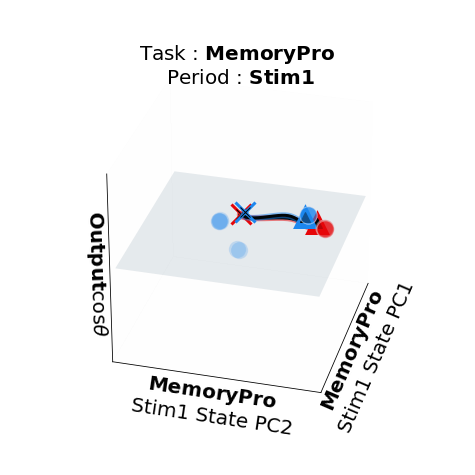

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

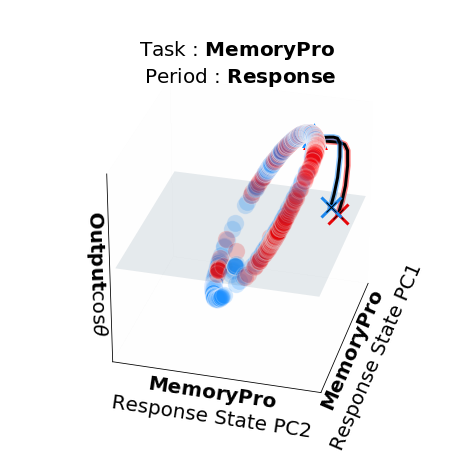

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

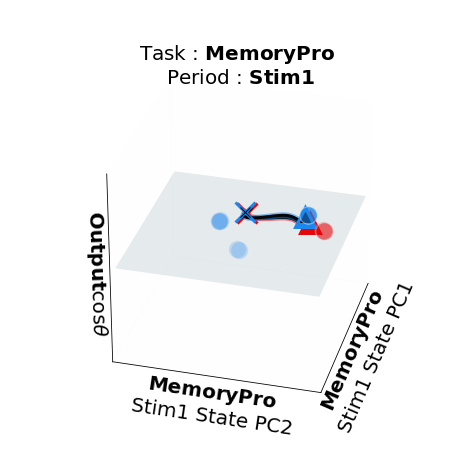

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameter

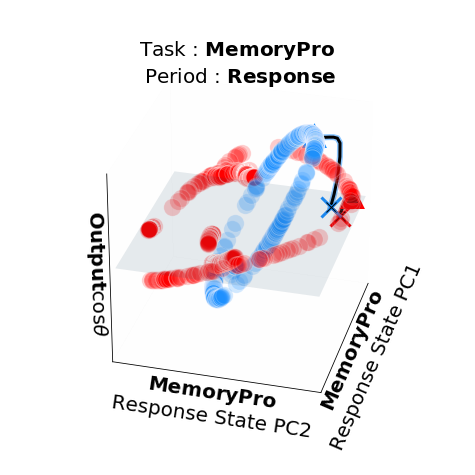

In [131]:
for t in [0,]:
    lesion_cluster = 6
    task_list = ['delaygo',]
    color_by = 'stim'

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['stim1',], q_thresh = 1e-9, t=t, view_init = [195,30])

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['go1',], q_thresh = 1e-5, t=t, view_init = [195,30])
    
    
    lesion_cluster = 3

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['stim1',], q_thresh = 1e-9, t=t, view_init = [195,30])

    compare_fp_lesions(m,cluster_var,lesion_cluster,task_list,review = True, 
                       epoch_set = ['go1',], q_thresh = 1e-5, t=t, view_init = [195,30])

from tools_lnd import same_mov_inds, get_interp_filename, gen_trials_from_model_dir, make_D_use, interp3d

rule_set = [5,5]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]

#make the axes stim related
epoch_set = ['stim1','stim1']

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = -D_use[:,0]
D_use[:,1] = D_use[:,1]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' Period \n State PC1',
             epoch_name_ax+' Period \n State PC2',
             epoch_name_ax+' Period \n State PC3']

epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'
interp = True

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = 6,figpath = figpath,
         ruleset = '2task_interp',alpha_fp = .1, stability_thresh = 2, ax_labels = ax_labels)

In [ ]:
from scipy.spatial import distance
from numpy import linalg as LA
from tools_lnd import eigenspectrum_axes
def dst_to_h(h,sorted_fps):
    X = np.squeeze(sorted_fps).astype(np.float64)
    dst = np.zeros((np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
            dst[xi] = distance.euclidean(h, X[xi,:])
    return dst

def proximate_fp(h,fps):
    if len(fps)==1:
        proximate_fps = 0
    else:
        sorted_fps_list = np.argsort(dst_to_h(h,fps))
        proximate_fps = sorted_fps_list[0]
    return proximate_fps

In [ ]:
def FP_PC_axes(ax):

    ax.set_xlabel('FP PC1',fontsize = 20)
    ax.set_ylabel('FP PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 

In [ ]:
def PC_axes(ax):

    ax.set_xlabel('h PC1',fontsize = 20)
    ax.set_ylabel('h PC2',fontsize = 20)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [ ]:
lesion_cluster = 6

In [ ]:
cmap_grad = plt.get_cmap('rainbow')
task_list = hp['rule_trains'][:-2]
n_tasks = len(task_list)
epoch = 'fix1'
ti = 0

fig = plt.figure(figsize=(3*2,3*n_tasks),tight_layout=True,facecolor='white')

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    B = np.shape(trial.y_loc)[1]
    trial_set = range(0,B,int(B/10))
    
    
    T_inds = get_T_inds(trial,epoch)
    out_theta = int(180*trial.y_loc[-1,ti]/np.pi)
    
    
    
    for subplot_i in range(2):

        if subplot_i>0:
            ind_l = np.where(CA.labels == lesion_cluster)[0]
            lesion_units_list = [CA.ind_active[ind_l]][0]
            f = os.path.join(m,'lesion_fps','tf_fixed_pts_lesion'+str(lesion_cluster+1),rule,epoch+'_'+str(out_theta)+'.0.npz')
            tit_lesion = 'LESION_'+str(lesion_cluster)
            a_plot = .8
            fp_color = 'r'
        else:
            lesion_units_list = []
            f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(out_theta)+'.0.npz')
            
            if not os.path.isfile(f):
                nonzero_stim = trial.stim_locs[0,:]<100
                stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
                filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
                f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)
                
            tit_lesion = 'NO_LESION'
            a_plot = .3
            fp_color = 'dodgerblue'

        fp_struct = np.load(f)
        xstar = fp_struct['xstar']
        
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units_list)

        if subplot_i==0:
            D_fp = {}
            pca = PCA(n_components = n_components)
            X_flat = np.reshape(h_all[:,ti,T_inds],(-1,hp['n_rnn']))
#             X_flat = xstar
            fp_pca = pca.fit_transform(X_flat)
            D_fp['axes'] = pca.components_.T
            D_fp['labels'] = ['PCA_'+str(x+1) for x in range(n_components)]
        
            D_use = D_fp['axes']
            axes_labels = D_fp['labels']

        h_ind = h_all[:,ti,T_inds[-1]]
        proximate_fps = proximate_fp(h_ind,xstar)
        fp_num = proximate_fps
        evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:]) 
        
        ax1 = fig.add_subplot(n_tasks,2,1+ri*2)
        D_h = np.dot(D_use.T,h_all[:,ti,T_inds])
        plt.plot(D_h[0,:],D_h[1,:],'-',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,0],D_h[1,0],'x',c = fp_color,alpha = a_plot)
        plt.plot(D_h[0,-1],D_h[1,-1],'^',c = fp_color,alpha = a_plot)
        D_fp_all = np.dot(D_use.T,xstar.T)
        plt.plot(D_fp_all[0,:],D_fp_all[1,:],'.',c = fp_color,markersize = 2,alpha = a_plot)
        D_fp_proximal = np.dot(D_use.T,xstar[fp_num,:])
        plt.plot(D_fp_proximal[0],D_fp_proximal[1],'o',c = fp_color,markersize = 10,alpha = a_plot)
        
        ax2 = fig.add_subplot(n_tasks,2,2+ri*2)
        ax2.plot(evals.real,evals.imag,'o',c = fp_color,markersize = 5,alpha = .3)
#         ax2.plot(evals.real,evals.imag,'.',c = fp_color,alpha = .3)
    
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    ax2.plot(xs, ys,':k',linewidth = 1)
    ax2.plot(xs, -ys,':k',linewidth = 1)
    plt.xlim((.5,1.1))
    plt.ylim((-.25,.25))
#     plt.xticks(fontsize = 18)
#     plt.yticks(fontsize = 18)
    eigenspectrum_axes(epoch,ax2)
    ax2.set_aspect('equal')  
    PC_axes(ax1) 
    ax1.set_title(rule +' '+ epoch + ' lesion# '+str(lesion_cluster))
    # ax1.set_aspect('equal') 
plt.show()

In [ ]:
def load_proximal_fp_from_f(f,h):
    fp_struct = np.load(f)
    xstar = fp_struct['xstar']
    
    proximate_fps = proximate_fp(h,xstar)
    fp_num = proximate_fps
    evals, _ = LA.eig(fp_struct['J_xstar'][fp_num,:,:])
    
    return xstar, fp_struct['J_xstar'], fp_num, evals

In [ ]:
class rnn_obj(object):

    default_hps = {
        'tf_dtype': 'float32',
        'random_seed': model_n,
        'rnn_cell_feed_dict': {},
    }

    def __init__(self, rnn_cell, sess,
        random_seed=default_hps['random_seed'],
        tf_dtype=default_hps['tf_dtype'],
        rnn_cell_feed_dict=default_hps['rnn_cell_feed_dict']):
        
        self.rnn_cell = rnn_cell
        self.rnn_cell_feed_dict = rnn_cell_feed_dict
        self.session = sess
        self.tf_dtype = getattr(tf, tf_dtype)
        
    def _grab_RNN(self, initial_states, inputs):

        x = tf.Variable(initial_states, dtype=self.tf_dtype)
        x_rnncell = x

        inputs_tf = tf.constant(inputs, dtype=self.tf_dtype)

        output, F_rnncell = self.rnn_cell(inputs_tf, x_rnncell)
        F = F_rnncell
        
        init = tf.variables_initializer(var_list=[x,])
        self.session.run(init)

        return x, F

In [ ]:
from tensorflow.python.ops import parallel_for as pfor
import absl

def calc_Jac(sess,rnn_o,feed_dict,states,inputs):
    x_tf, F_tf = rnn_o._grab_RNN(states, inputs)
    try:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf)
    except absl.flags._exceptions.UnparsedFlagAccessError:
       dFdx_tf = pfor.batch_jacobian(F_tf, x_tf, use_pfor=False)
    dFdx_np = sess.run(dFdx_tf)
    return dFdx_np

def calc_relevant_jacobian(m,fp_struct,fp_num):
    
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()

        rnn_o_hps = {}
        rnn_o = []
        rnn_o = rnn_obj(model.cell,sess, **rnn_o_hps) 

        state = fp_struct['xstar'][fp_num][np.newaxis,:]
        inputs = fp_struct['inputs'][fp_num][np.newaxis,:]

        dFdx = calc_Jac(sess,rnn_o,feed_dict,state,inputs)
    return dFdx

In [ ]:
len([])

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from tools_lnd import make_dendro

lesion_cluster = 8
epoch = 'go1'
ti = 0
task_list = hparams['rule_trains']

method = 'ward'
max_d = 3
lesion_folder = 'lesion_fps_hierarchical_'+method+'_max_d'+str(max_d)
save_dir = os.path.join(m,lesion_folder)
if not os.path.isfile(save_dir) :
    make_dendro(m)
    
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
D = cluster_var['D']
CA = cluster_var['CA']
clusters = cluster_var['clusters']
lesion_units_list = cluster_var['lesion_units_list']

lesion_effect[epoch] = {}

lesion_effect[epoch]['task_list'] = task_list
lesion_effect[epoch]['J_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['h_corr']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_start']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_h_end']= np.zeros(len(task_list))
lesion_effect[epoch]['dst_fp']= np.zeros(len(task_list))

for ri in range(len(task_list)):
    rule = task_list[ri]
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    
    if  epoch in trial.epochs.keys():
        
        T_inds = get_T_inds(trial,epoch)
        out_theta = int(180*trial.y_loc[-1,ti]/np.pi)

        #LESION
        lesion_units=lesion_units_list[lesion_cluster]
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(lesion_cluster),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
        fp_struct = np.load(f)
        
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_lesion = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_lesion[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_lesion = fp_struct['xstar'][fp_num,:]
        J_xstar_lesion = calc_relevant_jacobian(m,fp_struct,fp_num)
        
        #NO LESION
        lesion_units = []
        f = os.path.join(m,lesion_folder,'tf_fixed_pts_lesion_'+str(0),rule,epoch+'_'+str(out_theta)+'.0.npz')
        
#         if not os.path.isfile(f):
#             nonzero_stim = trial.stim_locs[0,:]<100
#             stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[ti,nonzero_stim])
#             filename = epoch+'_trial'+str(ti)+'_x'+stim_names+'_y'+str(out_theta)+'.npz'
#             f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename)

        fp_struct = np.load(f)
    
        #identify relevant fp
        _,h_all = gen_X_from_model_dir(m,trial,lesion_units_list = lesion_units)
        h_epoch_full = h_all[:,ti,T_inds]
        proximate_fps = proximate_fp(h_epoch_full[:,-1],fp_struct['xstar'])
        fp_num = proximate_fps
        xstar_full = fp_struct['xstar'][fp_num,:]
        J_xstar_full = calc_relevant_jacobian(m,fp_struct,fp_num)

        #correlation of Jacobian around FP
        J_full = J_xstar_full[0]
        J_lesion = J_xstar_lesion[0]
        pearson = np.corrcoef(J_full.flatten(),J_lesion.flatten())
        lesion_effect[epoch]['J_corr'][ri] = pearson[1,0]

        #correlation of hidden state traj
        pearson = np.corrcoef(h_epoch_full.flatten(),h_epoch_lesion.flatten())
        lesion_effect[epoch]['h_corr'][ri] = pearson[1,0]

        #dist of hidden state traj
        dst_h = [LA.norm(h_epoch_full[:,x] - h_epoch_lesion[:,x]) for x in range(np.shape(h_epoch_lesion)[1])]
        lesion_effect[epoch]['dst_h_start'][ri] = dst_h[0]
        lesion_effect[epoch]['dst_h_end'][ri] = dst_h[-1]

        #dist of proximal fp
        lesion_effect[epoch]['dst_fp'][ri] = LA.norm(xstar_full - xstar_lesion)
        
    else:
        lesion_effect[epoch]['J_corr'][ri] = np.NaN
        lesion_effect[epoch]['h_corr'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_start'][ri] = np.NaN
        lesion_effect[epoch]['dst_h_end'][ri] = np.NaN
        lesion_effect[epoch]['dst_fp'][ri] = np.NaN
        
# save cluster variables
lesion_effect_var = {epoch:lesion_effect[epoch]}
np.savez(os.path.join(save_dir,epoch+'_lesion_effect_var.npz'),**lesion_effect_var)
    

In [ ]:

save_dir = os.path.join(figpath,'lesion '+str(lesion_cluster))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
fig = plt.figure(figsize=(6,8),tight_layout=True,facecolor='white')
nc = len(lesion_effect[epoch].keys())-1
nr = 1

keys_list = np.sort(lesion_effect[epoch].keys())

for col_i in range(nc):
    ax1 = plt.subplot(nc,1,col_i+1)
    key = keys_list[col_i]
    plt.plot(lesion_effect[epoch][key][:-2],'.-k')
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    plt.ylabel(key)

    if col_i==0:
        plt.title(epoch+' lesion #'+str(lesion_cluster))
        ax1.set_xticks([])
    elif col_i==(nc-1):
        ax1.spines['bottom'].set_visible(False)
        task_list = lesion_effect[epoch]['task_list']
        ax1.set_xticks(range(len(task_list[:-2])))
        ax1.set_xticklabels(task_list[:-2],rotation = 40,ha='right')
    else:
        ax1.set_xticks([])

figname = epoch+'_fp_lesion_stats'
plt.savefig(os.path.join(save_dir,figname+'.pdf'))

In [ ]:
lesion_effect[epoch]['task_list']